## **6. Feature Extraction/ Embedding Function 2**

6.1 Bag of Words & Naive Bayes. BOW simplest method to turn text into numbers and NB it´s fast, and works well with words counts (*think of: Given the words I see, which class is more probable to be fake or real*)

6.2 Importing corresponding libriaries and loading the processed data. 
I have added a safty check, where if "text_clean" exist, use it, otherwise, fall back to "text"

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from joblib import dump, load
from pathlib import Path

DATA_DIR = Path(".")

# 1) Load your preprocessed data
train_df = pd.read_csv(DATA_DIR / "train_ready.csv")
test_df  = pd.read_csv(DATA_DIR / "test_ready.csv")
val_df   = pd.read_csv(DATA_DIR / "validation_ready.csv")
# Pick the preprocessed text column
TEXT_COL = "text_clean" if "text_clean" in train_df.columns else "text"

In [2]:
# 2) Embedding function: Bag of Words
def embed_bow(df: pd.DataFrame, vectorizer: CountVectorizer=None, text_col: str=TEXT_COL):
    """
    Turn preprocessed text into Bag-of-Words numeric vectors.
    If 'vectorizer' is None -> fit a new one; otherwise use the provided one.
    Returns: (X_sparse_matrix, fitted_vectorizer)
    """
    if vectorizer is None:
        vectorizer = CountVectorizer(
            ngram_range=(1, 2), 
            min_df=2,          
            max_df=0.9,         
            max_features=50000  
        )
        X = vectorizer.fit_transform(df[text_col].astype(str))
    else:
        X = vectorizer.transform(df[text_col].astype(str))
    return X, vectorizer

# 3) Build embeddings, as ML models cannot work on raw strings. 
X_train, bow_vec = embed_bow(train_df)
X_test,  _       = embed_bow(test_df,  vectorizer=bow_vec)
X_val,   _       = embed_bow(val_df,   vectorizer=bow_vec)

y_train = train_df["label"].values
y_test  = test_df["label"].values

# 4) Train Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# 5) Evaluate on test
y_pred_test = nb.predict(X_test)
acc  = accuracy_score(y_test, y_pred_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average="binary", pos_label=1)

print("=== Naive Bayes (Bag of Words) — Test Set ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred_test, digits=4))
print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred_test))

# 6) Predict the validation file (replace label=2 with model predictions)
val_pred = nb.predict(X_val)
val_out = val_df.copy()
if "label" in val_out.columns:
    val_out["label"] = val_pred
else:
    val_out.insert(0, "label", val_pred)

val_out.to_csv(DATA_DIR / "validation_data_predicted.csv", index=False)

# 7) Save model + vectorizer for reuse
dump(nb,        DATA_DIR / "nb_bow_model.pkl")
dump(bow_vec,   DATA_DIR / "bow_vectorizer.pkl")

=== Naive Bayes (Bag of Words) — Test Set ===
Accuracy : 0.9561
Precision: 0.9535
Recall   : 0.9590
F1-score : 0.9563

Classification report:
               precision    recall  f1-score   support

           0     0.9586    0.9531    0.9559      3989
           1     0.9535    0.9590    0.9563      4000

    accuracy                         0.9561      7989
   macro avg     0.9561    0.9561    0.9561      7989
weighted avg     0.9561    0.9561    0.9561      7989

Confusion matrix (rows=true, cols=pred):
 [[3802  187]
 [ 164 3836]]


['bow_vectorizer.pkl']

6.3 Confusion Matrix

=== Test Metrics ===
Accuracy : 0.9561
Precision: 0.9535
Recall   : 0.9590
F1-score : 0.9563

Classification report:
               precision    recall  f1-score   support

           0     0.9586    0.9531    0.9559      3989
           1     0.9535    0.9590    0.9563      4000

    accuracy                         0.9561      7989
   macro avg     0.9561    0.9561    0.9561      7989
weighted avg     0.9561    0.9561    0.9561      7989

Confusion matrix (rows=true, cols=pred):
 [[3802  187]
 [ 164 3836]]


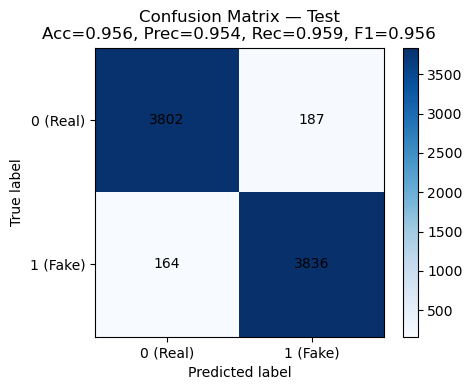

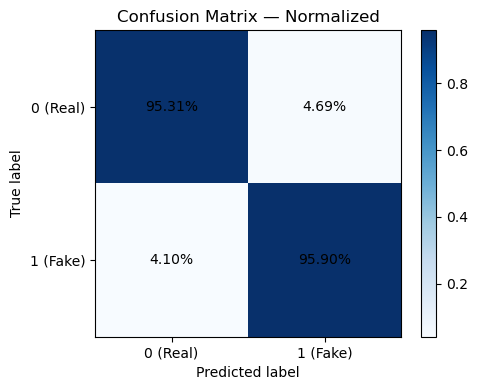

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
)

# 1) Compute metrics
cm   = confusion_matrix(y_test, y_pred_test)
acc  = accuracy_score(y_test, y_pred_test)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_test, average="binary", pos_label=1
)

print("=== Test Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred_test, digits=4))
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# 2) Plot confusion matrix (counts) with blue colors
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest", cmap="Blues")  # <-- Blue colormap
plt.title(f"Confusion Matrix — Test\nAcc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0,1], ["0 (Real)", "1 (Fake)"])
plt.yticks([0,1], ["0 (Real)", "1 (Fake)"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")  # black numbers
plt.colorbar()  # optional color bar
plt.tight_layout()
plt.show()

# 3) Normalized confusion matrix (percentages) with blue colors
import numpy as np
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5,4))
plt.imshow(cm_norm, interpolation="nearest", cmap="Blues")  # <-- Blue colormap
plt.title("Confusion Matrix — Normalized")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0,1], ["0 (Real)", "1 (Fake)"])
plt.yticks([0,1], ["0 (Real)", "1 (Fake)"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, f"{cm_norm[i, j]:.2%}", ha="center", va="center", color="black")  # black % text
plt.colorbar()
plt.tight_layout()
plt.show()